In [51]:
import seaborn as sns
from sklearn import neighbors
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostRegressor
import numpy as np
import pydot
from IPython.display import Image
from sklearn import tree

from io import StringIO

## ML2021 - Assesment Work (Regression)

The challenge is to predict Workers Compensation claims using realistic data.

**Model Evaluation**: MSE, $R^2$, ...

## Data Loading 




1. Download the train data

In [9]:
!wget https://github.com/curso-iabd-uclm/machinelearning/raw/main/insurance/train.csv

--2022-01-23 20:47:59--  https://github.com/curso-iabd-uclm/machinelearning/raw/main/insurance/train.csv
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/curso-iabd-uclm/machinelearning/main/insurance/train.csv [following]
--2022-01-23 20:48:00--  https://raw.githubusercontent.com/curso-iabd-uclm/machinelearning/main/insurance/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4942050 (4.7M) [text/plain]
Saving to: ‘train.csv.1’

train.csv.1         100%[===================>]   4.71M  --.-KB/s    in 0.1s    

2022-01-23 20:48:00 (45.9 MB/s) - ‘train.csv.1’ saved [4942050/4942050]



In [10]:
import pandas as pd
df = pd.read_csv("train.csv")
df.tail()

,ClaimNumber,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,HoursWorkedPerWeek,DaysWorkedPerWeek,ClaimDescription,InitialIncurredCalimsCost,UltimateIncurredClaimCost
36171,WC5624756,1996-05-29T09:00:00Z,1996-06-27T00:00:00Z,20,F,S,0,0,344.16,F,40.0,5,WALKED INTO DOOR BRUISED LEFT KNEE PAIN,1400,1343.054886
36172,WC8516685,2002-10-08T08:00:00Z,2003-02-07T00:00:00Z,35,M,M,0,0,1668.83,F,71.0,7,LIFTING HOT WATER FROM TRAY BURN LEFT WRIST,1000,172876.632600
36173,WC6891668,1999-09-22T09:00:00Z,1999-11-11T00:00:00Z,52,F,M,0,0,204.87,P,20.0,4,REMOVING BROKEN GLASS LACERATED LEFT THUMB,500,632.281472
36174,WC4287842,1993-02-05T06:00:00Z,1993-03-19T00:00:00Z,28,M,M,0,0,730.87,F,38.0,5,FELL OVER SPRAINED ANKLE AND KNEE INJURY,4000,6714.495760
36175,WC6368063,1998-03-06T10:00:00Z,1998-04-09T00:00:00Z,29,M,S,0,0,200.00,F,38.0,5,LIFTING METAL CYLINDER STRAIN NECK,3000,2588.845117


The training set containing 30,000 insurance policies that you can use to train your model.

**Data fields**

-  ClaimNumber: Unique policy identifier
- DateTimeOfAccident: Date and time of accident
- DateReported: Date that accident was reported
- Age: Age of worker
- Gender: Gender of worker
- MaritalStatus: Martial status of worker. (M)arried, (S)ingle, (U)unknown.
- DependentChildren: The number of dependent children
- DependentsOther: The number of dependants excluding children
- WeeklyWages: Total weekly wage
- PartTimeFullTime: Binary (P) or (F)
- HoursWorkedPerWeek: Total hours worked per week
- DaysWorkedPerWeek: Number of days worked per week
- ClaimDescription: Free text description of the claim
- InitialIncurredClaimCost: Initial estimate by the insurer of the claim cost
- **UltimateIncurredClaimCost**: Total claims payments by the insurance company. This is the field you are asked to predict in the test set.

In [11]:
df.columns

Index(['ClaimNumber', 'DateTimeOfAccident', 'DateReported', 'Age', 'Gender',
       'MaritalStatus', 'DependentChildren', 'DependentsOther', 'WeeklyWages',
       'PartTimeFullTime', 'HoursWorkedPerWeek', 'DaysWorkedPerWeek',
       'ClaimDescription', 'InitialIncurredCalimsCost',
       'UltimateIncurredClaimCost'],
      dtype='object')

In [12]:
df.head()

,ClaimNumber,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,HoursWorkedPerWeek,DaysWorkedPerWeek,ClaimDescription,InitialIncurredCalimsCost,UltimateIncurredClaimCost
0,WC8205482,2002-04-09T07:00:00Z,2002-07-05T00:00:00Z,48,M,M,0,0,500.00,F,38.0,5,LIFTING TYRE INJURY TO RIGHT ARM AND WRIST INJURY,1500,4748.203388
1,WC6922469,1999-01-07T11:00:00Z,1999-01-20T00:00:00Z,43,F,M,0,0,509.34,F,37.5,5,STEPPED AROUND CRATES AND TRUCK TRAY FRACTURE ...,5500,6326.285819
2,WC5442654,1996-03-25T00:00:00Z,1996-04-14T00:00:00Z,30,M,U,0,0,709.10,F,38.0,5,CUT ON SHARP EDGE CUT LEFT THUMB,1700,2293.949087
3,WC9796897,2005-06-22T13:00:00Z,2005-07-22T00:00:00Z,41,M,S,0,0,555.46,F,38.0,5,DIGGING LOWER BACK LOWER BACK STRAIN,15000,17786.487170
4,WC2603726,1990-08-29T08:00:00Z,1990-09-27T00:00:00Z,36,M,M,0,0,377.10,F,38.0,5,REACHING ABOVE SHOULDER LEVEL ACUTE MUSCLE STR...,2800,4014.002925


## Preprocessing

We transform the data in order to allow us the posterior use of the algorithms to build prediction models, for example, missing values, from categories to numbers, ...



### Missing Values

It is necessary to address the missing values to improve the quality of the data that will be used to generate the models. 

In [13]:
df.shape

(36176, 15)

In [14]:
pd.isnull(df).any()

ClaimNumber                  False
DateTimeOfAccident           False
DateReported                 False
Age                          False
Gender                       False
MaritalStatus                 True
DependentChildren            False
DependentsOther              False
WeeklyWages                   True
PartTimeFullTime             False
HoursWorkedPerWeek            True
DaysWorkedPerWeek            False
ClaimDescription             False
InitialIncurredCalimsCost    False
UltimateIncurredClaimCost    False
dtype: bool

In [15]:
df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)

In [16]:
df.shape

(36049, 15)

### OneHotEncoding 

[OneHotEncoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

In [17]:
df_OneHot = pd.get_dummies(df[['Gender','MaritalStatus', 'PartTimeFullTime']])
df_OneHot

,Gender_F,Gender_M,Gender_U,MaritalStatus_M,MaritalStatus_S,MaritalStatus_U,PartTimeFullTime_F,PartTimeFullTime_P
0,0,1,0,1,0,0,1,0
1,1,0,0,1,0,0,1,0
2,0,1,0,0,0,1,1,0
3,0,1,0,0,1,0,1,0
4,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...
36171,1,0,0,0,1,0,1,0
36172,0,1,0,1,0,0,1,0
36173,1,0,0,1,0,0,0,1
36174,0,1,0,1,0,0,1,0


> At the begining only the numerical and the encoded features must be considered.

> At the end of the work you can include text, date information and so on.

In [18]:
df_full = pd.concat([df, df_OneHot], axis = 1)
df_full.head()

,ClaimNumber,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,HoursWorkedPerWeek,DaysWorkedPerWeek,ClaimDescription,InitialIncurredCalimsCost,UltimateIncurredClaimCost,Gender_F,Gender_M,Gender_U,MaritalStatus_M,MaritalStatus_S,MaritalStatus_U,PartTimeFullTime_F,PartTimeFullTime_P
0,WC8205482,2002-04-09T07:00:00Z,2002-07-05T00:00:00Z,48,M,M,0,0,500.00,F,38.0,5,LIFTING TYRE INJURY TO RIGHT ARM AND WRIST INJURY,1500,4748.203388,0,1,0,1,0,0,1,0
1,WC6922469,1999-01-07T11:00:00Z,1999-01-20T00:00:00Z,43,F,M,0,0,509.34,F,37.5,5,STEPPED AROUND CRATES AND TRUCK TRAY FRACTURE ...,5500,6326.285819,1,0,0,1,0,0,1,0
2,WC5442654,1996-03-25T00:00:00Z,1996-04-14T00:00:00Z,30,M,U,0,0,709.10,F,38.0,5,CUT ON SHARP EDGE CUT LEFT THUMB,1700,2293.949087,0,1,0,0,0,1,1,0
3,WC9796897,2005-06-22T13:00:00Z,2005-07-22T00:00:00Z,41,M,S,0,0,555.46,F,38.0,5,DIGGING LOWER BACK LOWER BACK STRAIN,15000,17786.487170,0,1,0,0,1,0,1,0
4,WC2603726,1990-08-29T08:00:00Z,1990-09-27T00:00:00Z,36,M,M,0,0,377.10,F,38.0,5,REACHING ABOVE SHOULDER LEVEL ACUTE MUSCLE STR...,2800,4014.002925,0,1,0,1,0,0,1,0


### Train and test split

In [19]:
x_features = ['WeeklyWages', 'HoursWorkedPerWeek', 'InitialIncurredCalimsCost']


In [20]:
from sklearn.model_selection import train_test_split
X = df[x_features]
y = df['UltimateIncurredClaimCost']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)


## Basic Modeling 

We’ll be exploring Linear Regression using scikit-learn in python.

We will use the selected features to predict the results. 

Linear regression produces a model in the form:


 $$
 Y_{t}=\beta _{0}+\beta _{1}X_{1}+\beta _{2}X_{2}+\cdots +\beta _{p}X_{p}+\varepsilon
 $$

The way this is accomplished is by minimising the residual sum of squares, given by the equation below:
$$
RSS=Σni=1(yi–y^i)2
$$

$$
RSS=Σni=1(yi–β0^–β1^x1–β2^x2–…–βp^xp)
$$


Scikit-learn provides a LinearRegression function for doing this job.
Linear Regression (Dummy Model)

In [21]:
from sklearn import linear_model
model = linear_model.LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

Now that our model is trained, we can view the coefficients of the model using regression_model.coef_, which is an array of tuples of coefficients.

In [22]:
for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(col_name, model.coef_[idx]))

The coefficient for WeeklyWages is 9.794779343746388
The coefficient for HoursWorkedPerWeek is -25.675661234818307
The coefficient for InitialIncurredCalimsCost is 0.7743349854415342


Note that, because we’ve not done any feature scaling or dimensionality reduction, we can’t say anything about the relative importance of each of our features given these coefficients because the features are not of the same scale.

In [23]:
y_pred = model.predict(X_test)

In [24]:
from sklearn import metrics
print ("MAE:", metrics.mean_absolute_error(y_pred , y_test))
print ("MAPE:", metrics.mean_absolute_percentage_error(y_pred , y_test))
print ("MSE:", metrics.mean_squared_error(y_pred , y_test))
print ("R^2:", metrics.r2_score(y_pred , y_test))



MAE: 7979.755264779615
MAPE: 0.8024366465210745
MSE: 547594288.9830517
R^2: -1.5990659116870134


# 1. BaseLine (kNN or DecisionTrees)

- Feature Selection
- CrossValidation 
   - kNN: k, weights, metric (manhattan, euclidean)
   - Decisiontrees: max_depth


# 2. Optimized Model (RandomForests, Boosting + Hyperparameter Optimization)

# 3. Improvements (Include text data, other changes)

# 1. BaseLine (kNN or DecisionTrees)

<h2>1.1 Feature Selection<h2>


In [25]:
df.describe()

,Age,DependentChildren,DependentsOther,WeeklyWages,HoursWorkedPerWeek,DaysWorkedPerWeek,InitialIncurredCalimsCost,UltimateIncurredClaimCost
count,36049.000000,36049.000000,36049.000000,36049.000000,36049.000000,36049.000000,36049.000000,3.604900e+04
mean,33.793781,0.121279,0.009570,416.450612,37.766010,4.905684,7749.943993,1.096396e+04
std,12.117152,0.525212,0.106348,243.985721,12.505018,0.547290,18236.222960,3.534762e+04
min,13.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.218868e+02
25%,23.000000,0.000000,0.000000,200.000000,38.000000,5.000000,700.000000,9.268274e+02
50%,32.000000,0.000000,0.000000,393.300000,38.000000,5.000000,2000.000000,3.373446e+03
75%,43.000000,0.000000,0.000000,500.000000,40.000000,5.000000,9500.000000,8.192168e+03
max,79.000000,9.000000,3.000000,7497.000000,640.000000,7.000000,830000.000000,4.027136e+06


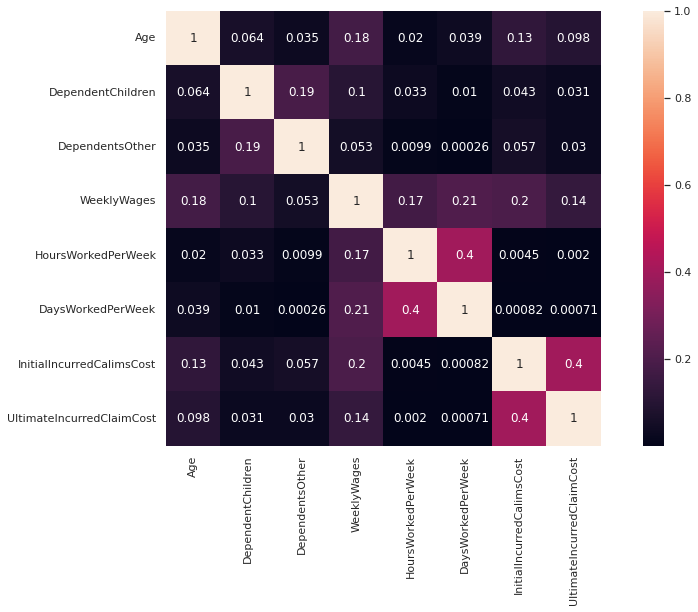

In [26]:

sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(df.corr(), square=True, annot=True)

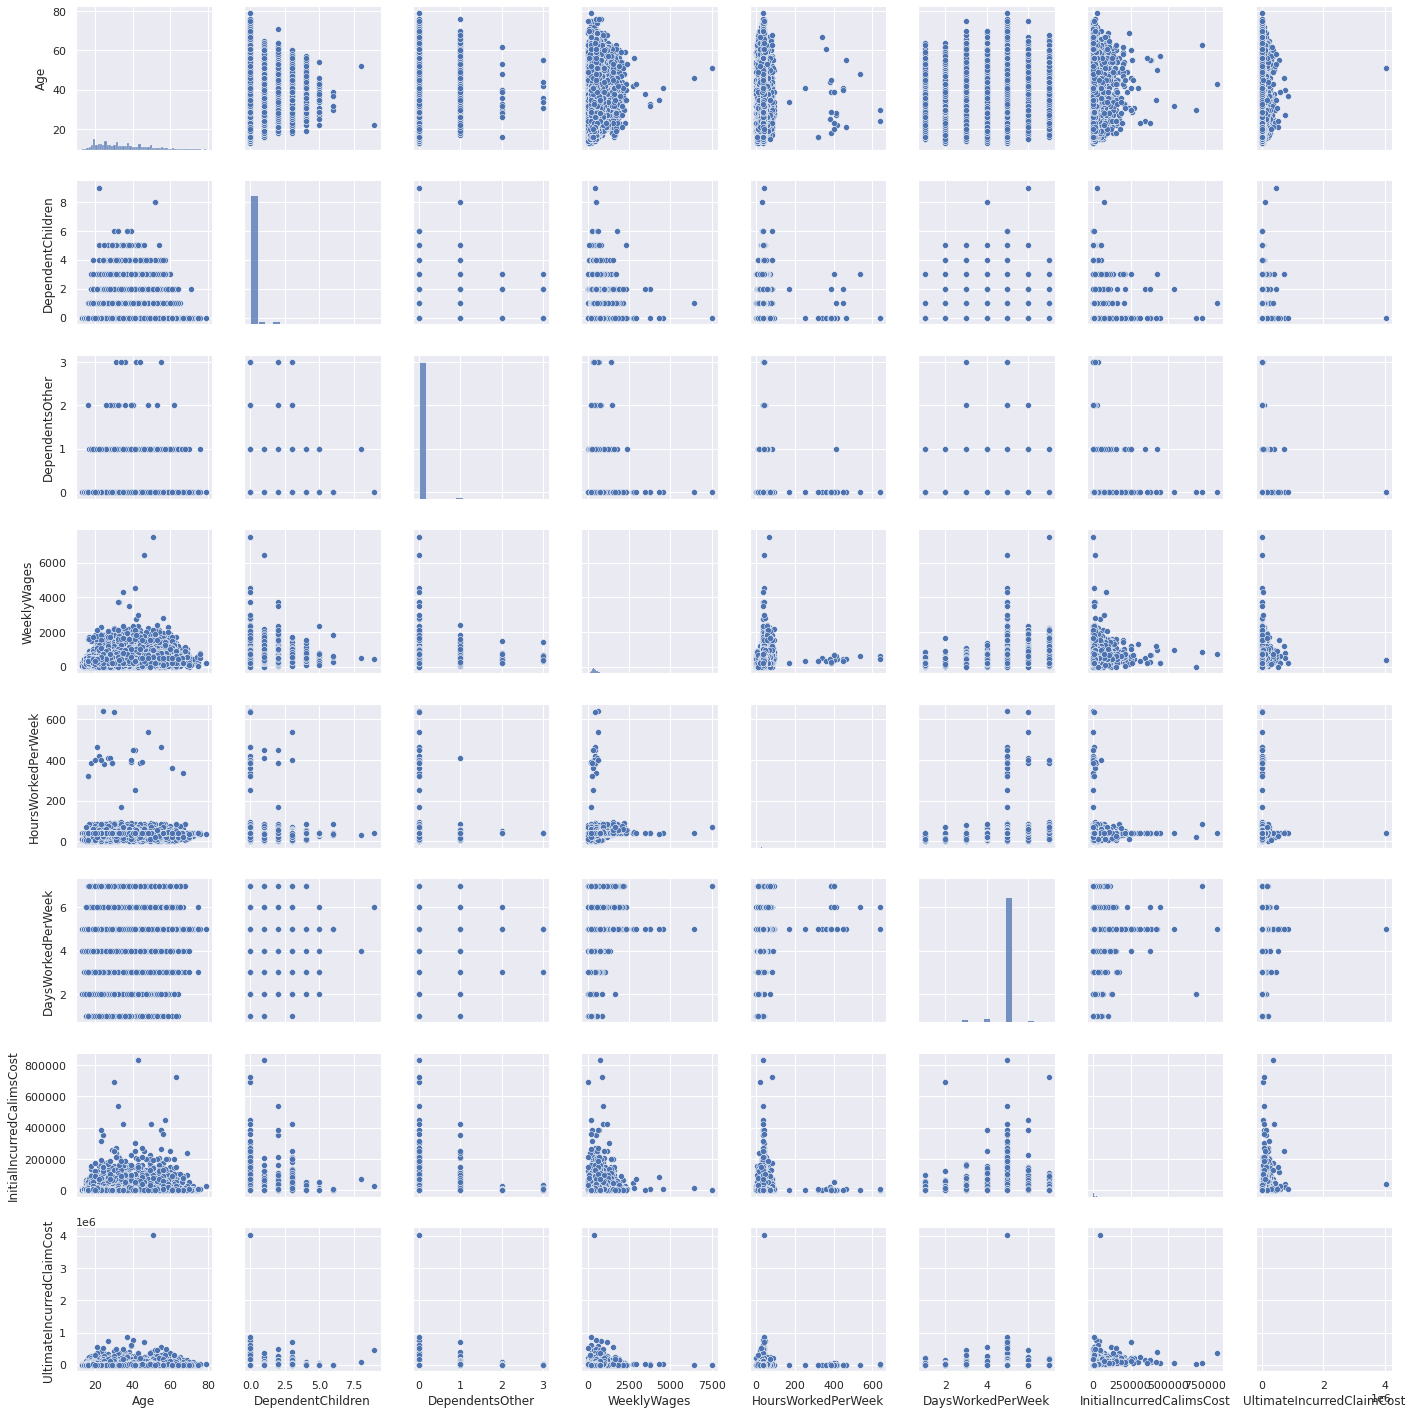

In [27]:
%matplotlib inline
sns.pairplot(df);

<h2>1.2 Cross Validation<h2>

In [28]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
test.head()

,WeeklyWages,HoursWorkedPerWeek,InitialIncurredCalimsCost,UltimateIncurredClaimCost
10886,200.0,38.0,10000,4144.215236
15578,200.0,38.0,10000,14064.601780
14788,200.0,38.0,751,1006.211706
22229,200.0,40.0,9500,5689.307618
30954,736.1,38.0,11000,44014.967590


KNN Cross using MAE error as metric:




Min Value uniform : 7674.204899549508 (29)
Min Value distance : 7832.176673565171 (29)


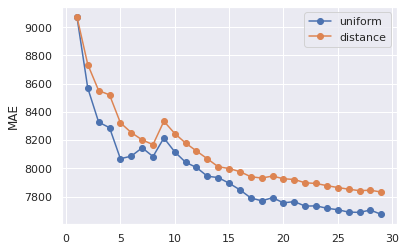

In [29]:
cv = KFold(n_splits = 10, shuffle = False) #
for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in range(1,30):
       fold_accuracy = []
       knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
       for train_fold, test_fold in cv.split(train):
          f_train = train
          f_test = test
          knn.fit( X = f_train.drop(['UltimateIncurredClaimCost'], axis=1), 
                               y = f_train['UltimateIncurredClaimCost'])
          y_pred = knn.predict(X = f_test.drop(['UltimateIncurredClaimCost'], axis = 1))
          mae = mean_absolute_error(f_test['UltimateIncurredClaimCost'], y_pred)
          fold_accuracy.append(mae)
       total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   
   plt.plot(range(1,len(total_scores)+1), total_scores, 
             marker='o', label=weights)
   print ('Min Value ' +  weights + " : " +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
   plt.ylabel('MAE')      
    

plt.legend()
plt.show() 


PREDICTION

In [30]:
# constructor
n_neighbors = 7
weights = 'uniform'
knn = neighbors.KNeighborsRegressor(n_neighbors= n_neighbors, weights=weights) 
# fit and predict
knn.fit( X = train.drop(['UltimateIncurredClaimCost'], axis=1), y = train['UltimateIncurredClaimCost'])
y_pred = knn.predict(X = test.drop(['UltimateIncurredClaimCost'], axis = 1))
mae = mean_absolute_error(test['UltimateIncurredClaimCost'], y_pred)
print ('MAE', mae)

MAE 8146.02836033875


VISUALIZATION

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


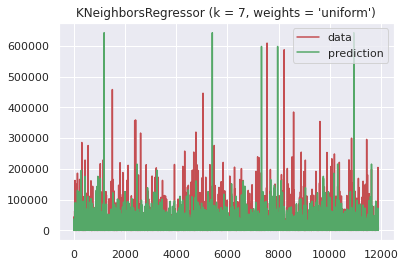

In [31]:

# x axis for plotting
import numpy as np
xx = np.stack(i for i in range(test['UltimateIncurredClaimCost'].shape[0]))
plt.plot(xx, test['UltimateIncurredClaimCost'], c='r', label='data')
#plt.plot(xx, y, c='k', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors,
                                                                weights))
plt.show()

<h2>1.3 Decision Trees<h2>

ONE FEATURE MODEL

In [32]:
# Model Parametrization 
# criterion: mse mean squared error, which is equal to variance reduction as feature selection criterion
# splitter: best/random
# max_depth: low value avoid overfitting
regressor = DecisionTreeRegressor(criterion='mse', max_depth=2, random_state=0)

In [33]:
# Model construction
# one feature predictor
regressor.fit(df[['InitialIncurredCalimsCost']], df['UltimateIncurredClaimCost'])

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


DecisionTreeRegressor(criterion='mse', max_depth=2, random_state=0)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  "X does not have valid feature names, but"


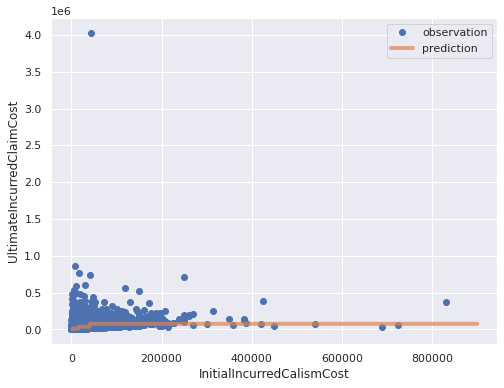

In [34]:
# Model Plot
xx = np.array([np.linspace(3000, 900000, 5000)]).T

plt.figure(figsize=(8,6))
plt.plot(df['InitialIncurredCalimsCost'], df['UltimateIncurredClaimCost'], 'o', label='observation')
plt.plot(xx, regressor.predict(xx), linewidth=4, alpha=.7, label='prediction')
plt.xlabel('InitialIncurredCalismCost')
plt.ylabel('UltimateIncurredClaimCost')
plt.legend()
plt.show()

TWO FEATURES MODEL

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  "X does not have valid feature names, but"


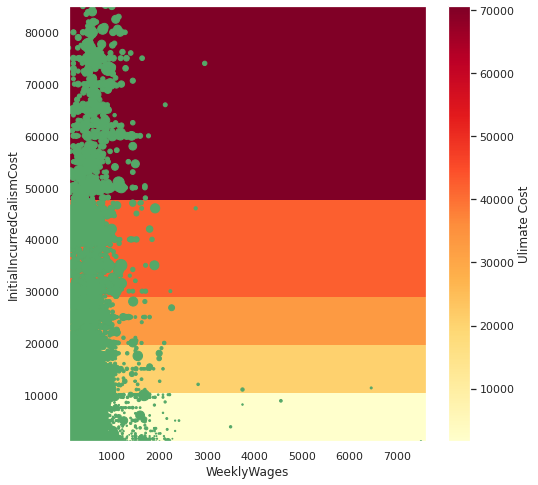

In [35]:
#Model Parametrization 
# criterion: mse mean squared error, which is equal to variance reduction as feature selection criterion
# splitter: best/random
# max_depth: low value avoid overfitting
regressor = DecisionTreeRegressor(criterion='mse', max_depth=3, random_state=0)
#1.2 Model construction
regressor.fit(df[['WeeklyWages', 'InitialIncurredCalimsCost']], df['UltimateIncurredClaimCost'])

# This visualization is only useful for a model of two predictors

nx = 10
ny = 10
# creating a grid of points
x_wages = np.linspace(100, 7600, nx)
y_initial = np.linspace(1000, 85000, ny)
xx, yy = np.meshgrid(x_wages, y_initial)
# evaluating the regresson on all the points
z_final = regressor.predict(np.array([xx.flatten(), yy.flatten()]).T)
zz = np.reshape(z_final, (nx, ny))


fig = plt.figure(figsize=(8, 8))
# plotting the predictions
plt.pcolormesh(x_wages, y_initial, zz, cmap=plt.cm.YlOrRd)
plt.colorbar(label='Ulimate Cost') # add a colorbar on the right
# plotting also the observations
plt.scatter(df['WeeklyWages'], df['InitialIncurredCalimsCost'], s=df['UltimateIncurredClaimCost']/2000.0, c='g')
# setting the limit for each axis
plt.xlim(np.min(x_wages), np.max(x_wages))
plt.ylim(np.min(y_initial), np.max(y_initial))
plt.xlabel('WeeklyWages')
plt.ylabel('InitialIncurredCalismCost')
plt.show()

THREE FEATURES MODEL

In [36]:
regressor = DecisionTreeRegressor(criterion='mse', max_depth=2, random_state=0)
features = ['WeeklyWages', 'HoursWorkedPerWeek', 'InitialIncurredCalimsCost']
regressor.fit(df[features], df['UltimateIncurredClaimCost'])

print ('Feature Relevances')
pd.DataFrame({'Attributes': features ,
              'Decision Tree': regressor.feature_importances_})

Feature Relevances


/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


,Attributes,Decision Tree
0,WeeklyWages,0.0
1,HoursWorkedPerWeek,0.0
2,InitialIncurredCalimsCost,1.0


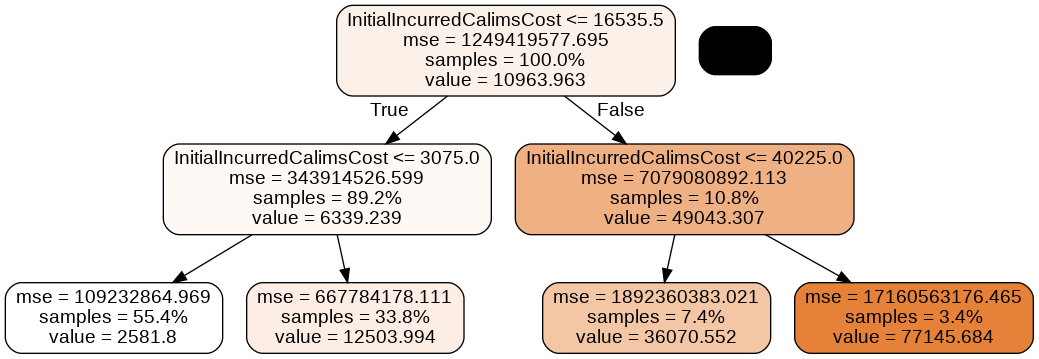

In [37]:
dot_data = StringIO()
tree.export_graphviz(regressor, out_file = dot_data, proportion = True,
                     feature_names = ['WeeklyWages', 'HoursWorkedPerWeek', 'InitialIncurredCalimsCost'],
                      rounded = True, filled = True)

graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())

PARAMETRIZATION


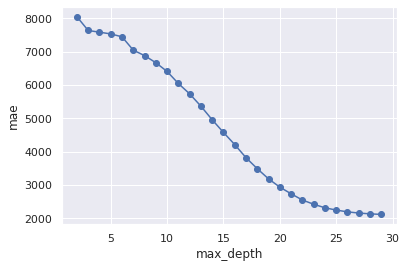

In [38]:
# Compute the max 
mae = []

for i in range(2, 30):
    regressor = DecisionTreeRegressor(max_depth=i)
    regressor.fit(df[['WeeklyWages', 'InitialIncurredCalimsCost']], df['UltimateIncurredClaimCost'])
    pred_values = regressor.predict(df[['WeeklyWages', 'InitialIncurredCalimsCost']])
    maev = mean_absolute_error(df['UltimateIncurredClaimCost'],pred_values)
    mae.append(maev)
    
# Plot mae   
plt.plot(range(2,30), mae, marker='o')
plt.xlabel('max_depth')
plt.ylabel('mae')
plt.show()

In [39]:
# TimeSeriesSplit
cv = TimeSeriesSplit(n_splits = 10) 

total_scores = []
# probar con diferentes profundidades
for i in range(1,30):
    fold_accuracy = []
    dt = DecisionTreeRegressor(max_depth=i)

No handles with labels found to put in legend.


Min Value  :7468.5437736132935 (3)


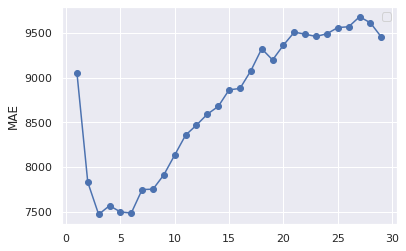

In [40]:
total_scores = []
for i in range(1,30):
    fold_accuracy = []
    dt = DecisionTreeRegressor(max_depth=i)
    for train_fold, test_fold in cv.split(train):
      f_train = train
      f_test = test
      dt.fit( X = f_train.drop(['UltimateIncurredClaimCost'], axis=1), 
                            y = f_train['UltimateIncurredClaimCost'])
      y_pred = dt.predict(X = f_test.drop(['UltimateIncurredClaimCost'], axis = 1))
      mae = mean_absolute_error(f_test['UltimateIncurredClaimCost'], y_pred)
      fold_accuracy.append(mae)
    total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   
plt.plot(range(1,len(total_scores)+1), total_scores, 
           marker='o')
print ('Min Value  :' +  str(min(total_scores)) +' (' + str(np.argmin(total_scores) + 1) + ')')
plt.ylabel('MAE')      
    

plt.legend()
plt.show() 

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


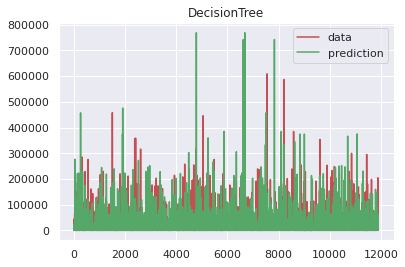

In [41]:
xx = np.stack(i for i in range(test['UltimateIncurredClaimCost'].shape[0]))
plt.plot(xx, test['UltimateIncurredClaimCost'], c='r', label='data')
#plt.plot(xx, y, c='k', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("DecisionTree")

plt.show()

<h1> 2. OPTIMIZED MODEL <h1>

<h2> 2.1 Random Forests <h2>



In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
#Model Parametrization 
regressor = RandomForestRegressor(n_estimators= 4, max_depth = 2, criterion='mae', random_state=0)
#Model construction
regressor.fit(X_train, y_train)
# Test
y_pred = regressor.predict(X_test)
#metrics calculation 
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test,y_pred)
print ("Error Measure ",  mae)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


Error Measure  6126.417761099787


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


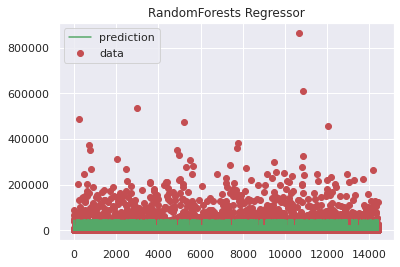

In [43]:
xx = np.stack(i for i in range(len(y_test)))
plt.scatter(xx, y_test, c='r', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("RandomForests Regressor")

plt.show()

In [44]:
df.head()

,ClaimNumber,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,HoursWorkedPerWeek,DaysWorkedPerWeek,ClaimDescription,InitialIncurredCalimsCost,UltimateIncurredClaimCost
0,WC8205482,2002-04-09T07:00:00Z,2002-07-05T00:00:00Z,48,M,M,0,0,500.00,F,38.0,5,LIFTING TYRE INJURY TO RIGHT ARM AND WRIST INJURY,1500,4748.203388
1,WC6922469,1999-01-07T11:00:00Z,1999-01-20T00:00:00Z,43,F,M,0,0,509.34,F,37.5,5,STEPPED AROUND CRATES AND TRUCK TRAY FRACTURE ...,5500,6326.285819
2,WC5442654,1996-03-25T00:00:00Z,1996-04-14T00:00:00Z,30,M,U,0,0,709.10,F,38.0,5,CUT ON SHARP EDGE CUT LEFT THUMB,1700,2293.949087
3,WC9796897,2005-06-22T13:00:00Z,2005-07-22T00:00:00Z,41,M,S,0,0,555.46,F,38.0,5,DIGGING LOWER BACK LOWER BACK STRAIN,15000,17786.487170
4,WC2603726,1990-08-29T08:00:00Z,1990-09-27T00:00:00Z,36,M,M,0,0,377.10,F,38.0,5,REACHING ABOVE SHOULDER LEVEL ACUTE MUSCLE STR...,2800,4014.002925


In [45]:
regressor = RandomForestRegressor(n_estimators= 4, max_depth = 2, criterion='mae', random_state=0)
features = ['WeeklyWages', 'HoursWorkedPerWeek', 'InitialIncurredCalimsCost']
regressor.fit(df[features], df['UltimateIncurredClaimCost'])
print ('Feature Relevances')
pd.DataFrame({'Attributes': features ,
              'Decision Tree': regressor.feature_importances_})

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


Feature Relevances


,Attributes,Decision Tree
0,WeeklyWages,0.0
1,HoursWorkedPerWeek,0.0
2,InitialIncurredCalimsCost,1.0


<h2> 2.2 BOOSTING + HYPERPARAMETER OPTIMIZATION

In [56]:
ada=AdaBoostRegressor()
search_grid={'n_estimators':[500,1000,2000],'learning_rate':[.001,0.01,.1],'random_state':[1]}
search=GridSearchCV(estimator=ada,param_grid=search_grid,scoring='neg_mean_squared_error',n_jobs=1,cv=5)
search.fit(X,y)


GridSearchCV(cv=5, estimator=AdaBoostRegressor(), n_jobs=1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'n_estimators': [500, 1000, 2000],
                         'random_state': [1]},
             scoring='neg_mean_squared_error')

In [60]:
y_pred = search.predict(X)

In [62]:
mae = mean_absolute_error(df['UltimateIncurredClaimCost'], y_pred)
print ('MAE', mae)

MAE 8221.691677509963
